# Estratégia de Retenção de Clientes - Model Fitness

## 1. Contexto do Projeto
A rede de academias Model Fitness está enfrentando problemas com a rotatividade de clientes (churn). O objetivo deste projeto é analisar os dados dos clientes para identificar padrões de cancelamento e propor uma estratégia de retenção baseada em dados.

## 2. Objetivos
* **Predição:** Criar um modelo de Machine Learning para prever a probabilidade de um cliente sair no próximo mês.
* **Clusterização:** Segmentar os clientes em grupos com perfis semelhantes para ações de marketing direcionadas.
* **Insights:** Identificar os principais fatores que levam à saída do cliente.

## 3. Dicionário de Dados
* `Churn`: Rotatividade no mês atual (Variável Alvo).
* `Near_Location`: Cliente mora/trabalha perto.
* `Partner`: Funcionário de empresa parceira.
* `Promo_friends`: Inscrição via "traga um amigo".
* `Phone`: Telefone cadastrado.
* `Contract_period`: Duração do contrato (1, 3, 6, 12 meses).
* `Group_visits`: Frequenta aulas em grupo.
* `Avg_additional_charges_total`: Gastos extras (café, massagem, etc).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

df = pd.read_csv('/datasets/gym_churn_us.csv')

print(" Estrutura e Amostra dos Dados:")
print(df.info())
print("\nPrimeiras 5 linhas:")
print(df.head())

 Estrutura e Amostra dos Dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_tota

## 4. Análise Exploratória de Dados (EDA)
Nesta etapa, vamos investigar a distribuição das variáveis e buscar correlações. Queremos entender: existem valores ausentes? Qual a média de gastos e frequência dos clientes que saem vs. os que ficam?

**Principais análises:**
1. Verificação de valores nulos e duplicados.
2. Comparação de médias entre grupos (Churn=0 vs Churn=1).
3. Matriz de correlação para identificar multicolinearidade.

In [2]:
print("\n Estatísticas Descritivas:")
print(df.describe().T)


 Estatísticas Descritivas:
                                    count        mean        std        min  \
gender                             4000.0    0.510250   0.499957   0.000000   
Near_Location                      4000.0    0.845250   0.361711   0.000000   
Partner                            4000.0    0.486750   0.499887   0.000000   
Promo_friends                      4000.0    0.308500   0.461932   0.000000   
Phone                              4000.0    0.903500   0.295313   0.000000   
Contract_period                    4000.0    4.681250   4.549706   1.000000   
Group_visits                       4000.0    0.412250   0.492301   0.000000   
Age                                4000.0   29.184250   3.258367  18.000000   
Avg_additional_charges_total       4000.0  146.943728  96.355602   0.148205   
Month_to_end_contract              4000.0    4.322750   4.191297   1.000000   
Lifetime                           4000.0    3.724750   3.749267   0.000000   
Avg_class_frequency_tota

In [3]:
print(" Comparação da Média entre Clientes que Sairam (1) e Ficaram (0):")
print(df.groupby('Churn').mean().T)

 Comparação da Média entre Clientes que Sairam (1) e Ficaram (0):
Churn                                       0           1
gender                               0.510037    0.510839
Near_Location                        0.873086    0.768143
Partner                              0.534195    0.355325
Promo_friends                        0.353522    0.183789
Phone                                0.903709    0.902922
Contract_period                      5.747193    1.728558
Group_visits                         0.464103    0.268615
Age                                 29.976523   26.989632
Avg_additional_charges_total       158.445715  115.082899
Month_to_end_contract                5.283089    1.662582
Lifetime                             4.711807    0.990575
Avg_class_frequency_total            2.024876    1.474995
Avg_class_frequency_current_month    2.027882    1.044546


### 4.1 Visualização das Características
Analisamos a distribuição das variáveis categóricas (Gênero, Parceiro, etc.) e contínuas (Idade, Lifetime) para identificar padrões visuais de cancelamento.

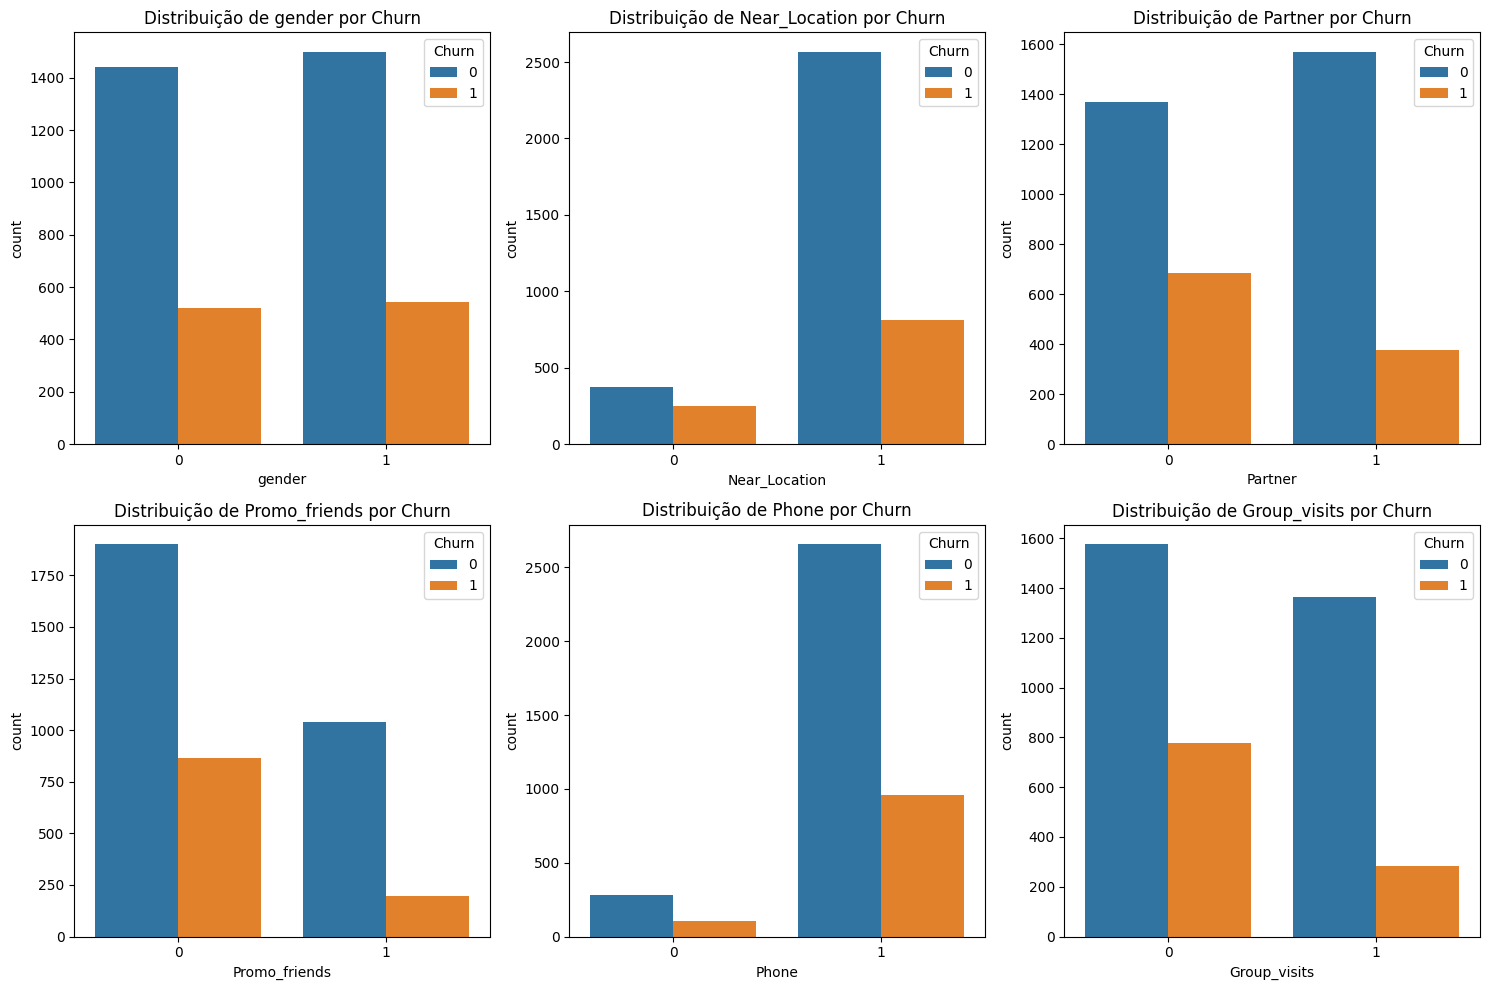

In [4]:
# Histograma para características binárias e categóricas
plt.figure(figsize=(15, 10))
binary_cols = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits']
for i, col in enumerate(binary_cols):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'Distribuição de {col} por Churn')
plt.tight_layout()
plt.show()

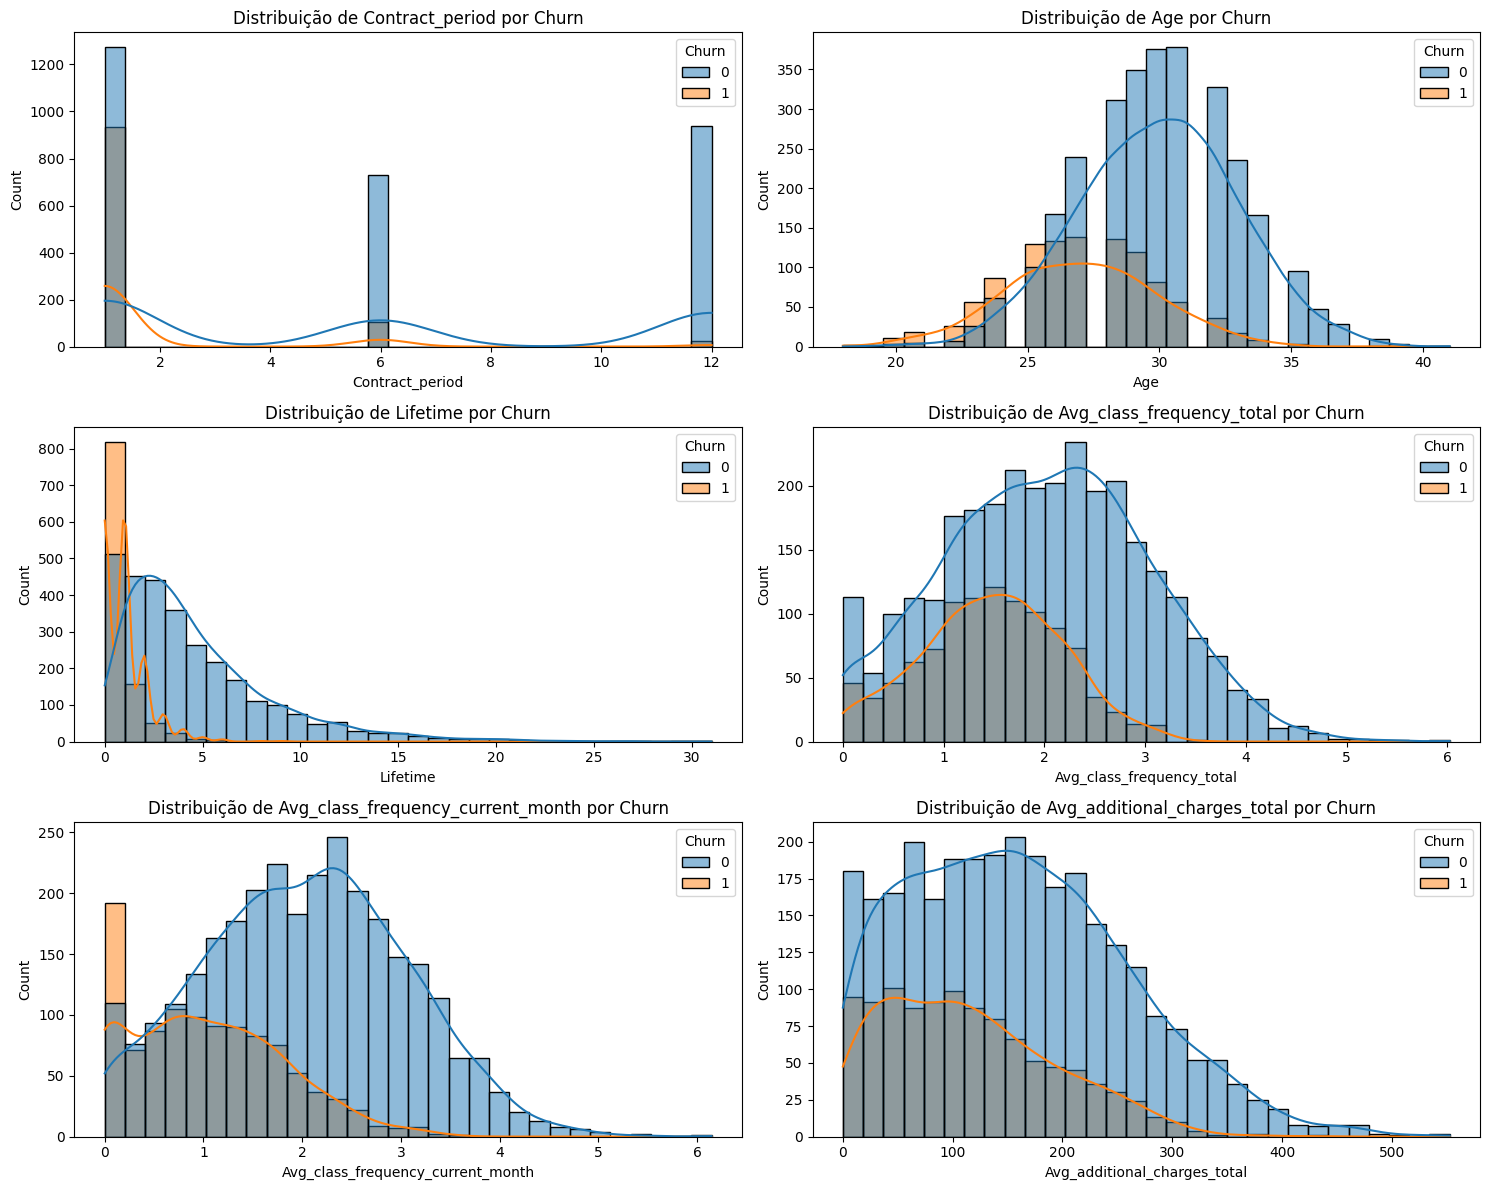

In [5]:
# Distribuição de Características Contínuas
plt.figure(figsize=(15, 12))
continuous_cols = ['Contract_period', 'Age', 'Lifetime', 'Avg_class_frequency_total', 
                   'Avg_class_frequency_current_month', 'Avg_additional_charges_total']
for i, col in enumerate(continuous_cols):
    plt.subplot(3, 2, i + 1)
    sns.histplot(data=df, x=col, hue='Churn', kde=True, bins=30)
    plt.title(f'Distribuição de {col} por Churn')
plt.tight_layout()
plt.show()

### 4.2 Matriz de Correlação
Verificamos a correlação entre as variáveis para evitar multicolinearidade nos modelos lineares e entender quais fatores têm maior relação com o Churn.

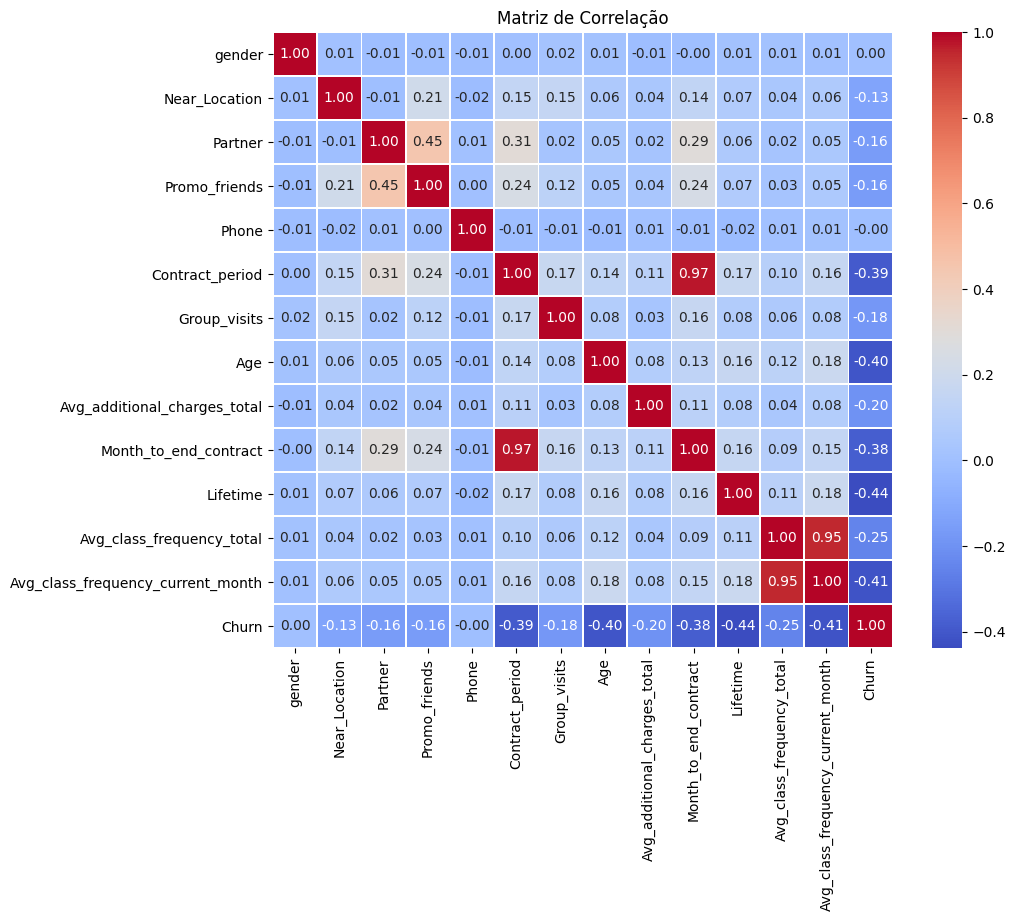

In [6]:
# Matriz de correlação
cm = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', linewidths=.5, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

## 5. Modelos de Predição de Churn (Classificação)
O objetivo é prever se o cliente sairá no próximo mês.
1. **Preparação:** Divisão em Treino/Teste e padronização dos dados (`StandardScaler`).
2. **Modelos:** Comparação entre **Regressão Logística** e **Random Forest**.

In [7]:
# Separar features (X) e target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Dividir dados de treino e validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Função de avaliação
def evaluate_model(y_true, y_pred):
    print(f'Acurácia: {accuracy_score(y_true, y_pred):.2f}')
    print(f'Precisão: {precision_score(y_true, y_pred):.2f}')
    print(f'Sensibilidade (Recall): {recall_score(y_true, y_pred):.2f}')

print("Divisão e Padronização concluídas.")
print(f"Dimensão dos dados de Treino (Padronizados): {X_train_scaled.shape}")
print(f"Dimensão dos dados de Teste: {X_test.shape}")


Divisão e Padronização concluídas.
Dimensão dos dados de Treino (Padronizados): (3200, 13)
Dimensão dos dados de Teste: (800, 13)


In [8]:
# Regressão Logística
print("\n--- Regressão Logística ---")

model_lr = LogisticRegression(random_state=42, solver='liblinear')
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)
evaluate_model(y_test, y_pred_lr)


--- Regressão Logística ---
Acurácia: 0.92
Precisão: 0.87
Sensibilidade (Recall): 0.78


In [9]:
# Floresta Aleatória
print("\n--- Floresta Aleatória ---")

model_rf = RandomForestClassifier(random_state=42, n_estimators=100) 
model_rf.fit(X_train_scaled, y_train)
y_pred_rf = model_rf.predict(X_test_scaled)
evaluate_model(y_test, y_pred_rf)


--- Floresta Aleatória ---
Acurácia: 0.91
Precisão: 0.85
Sensibilidade (Recall): 0.78


## 6. Clusterização de Clientes
Para traçar estratégias de marketing, não podemos tratar todos os alunos igual. Usaremos o **K-Means** para segmentar a base em 5 grupos de comportamento.

* **Dendrograma:** Visualização hierárquica para estimar o número de clusters.
* **K-Means:** Agrupamento final com n=5.

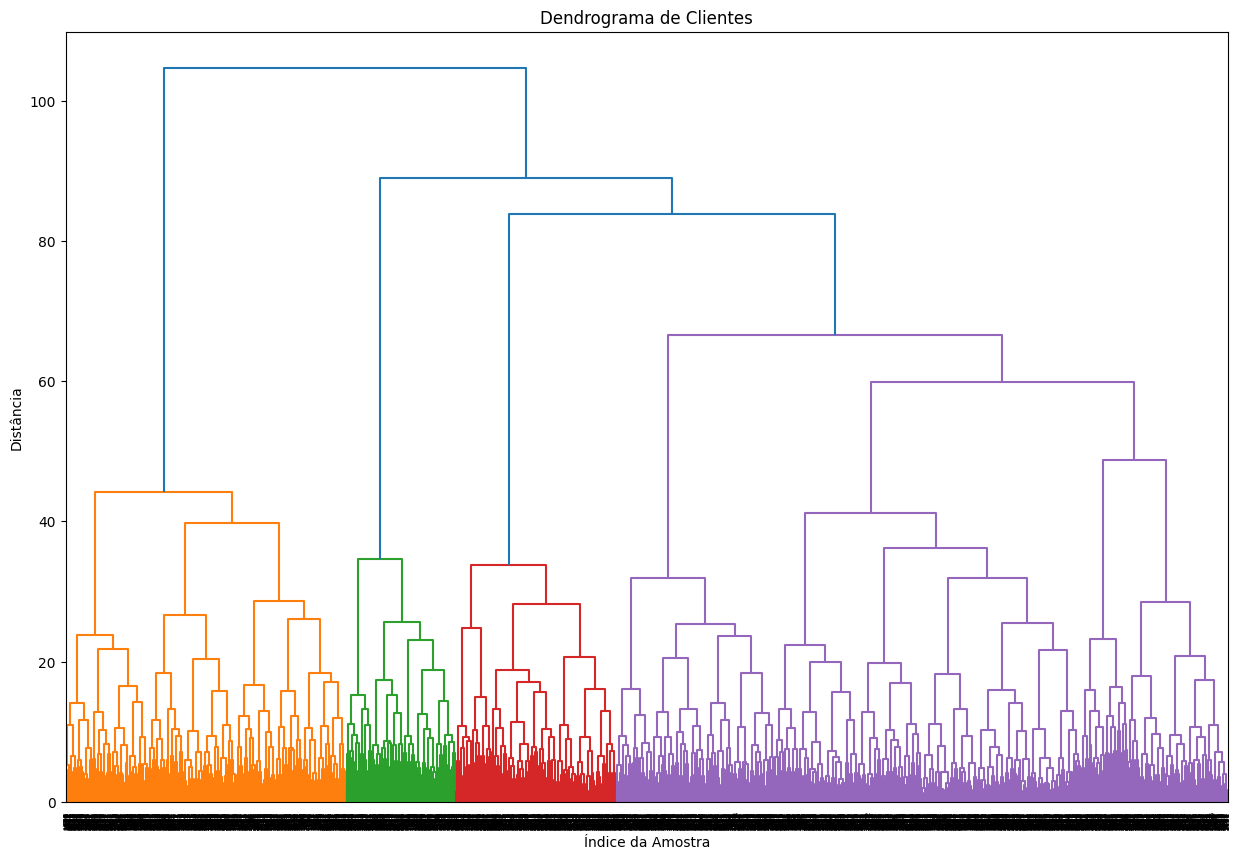

In [10]:
# Padronização dos Dados (Reutilizando scaler)
X_cluster = df.drop('Churn', axis=1)
scaler_cluster = StandardScaler()
X_scaled_cluster = scaler_cluster.fit_transform(X_cluster)

# Matriz de Distâncias e Dendrograma
linked = linkage(X_scaled_cluster, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Dendrograma de Clientes')
plt.xlabel('Índice da Amostra')
plt.ylabel('Distância')
plt.show()

### 6.1 Perfil dos Clusters
Abaixo, analisamos as médias de cada cluster e a taxa de cancelamento (Churn Rate) para definir o perfil de cada grupo.

In [11]:
# Treinar K-Means com n=5
km = KMeans(n_clusters=5, random_state=42, n_init=10)
df['cluster_km'] = km.fit_predict(X_scaled_cluster) 

print("---  Análise dos Clusters (K-Means) ---")

# Valores médios das características para cada cluster
cluster_means = df.groupby('cluster_km').mean().T
print(" Valores Médios das Características por Cluster:")
print(cluster_means)

# Calcular a Taxa de Rotatividade por Cluster
churn_rate = df.groupby('cluster_km')['Churn'].mean().reset_index()
churn_rate['Churn_Rate_%'] = (churn_rate['Churn'] * 100).round(2)

print(" Taxa de Rotatividade por Cluster:")
print(churn_rate[['cluster_km', 'Churn_Rate_%']])

---  Análise dos Clusters (K-Means) ---
 Valores Médios das Características por Cluster:
cluster_km                                  0           1           2  \
gender                               0.502370    0.554556    0.499422   
Near_Location                        0.949447    0.849269    0.937572   
Partner                              0.829384    0.263217    0.737572   
Promo_friends                        0.998420    0.052868    0.478613   
Phone                                1.000000    1.000000    1.000000   
Contract_period                      3.097946    2.606299   11.854335   
Group_visits                         0.448657    0.436445    0.546821   
Age                                 29.104265   30.008999   29.905202   
Avg_additional_charges_total       141.774331  159.774265  163.509804   
Month_to_end_contract                2.887836    2.419573   10.812717   
Lifetime                             3.772512    4.780652    4.677457   
Avg_class_frequency_total          

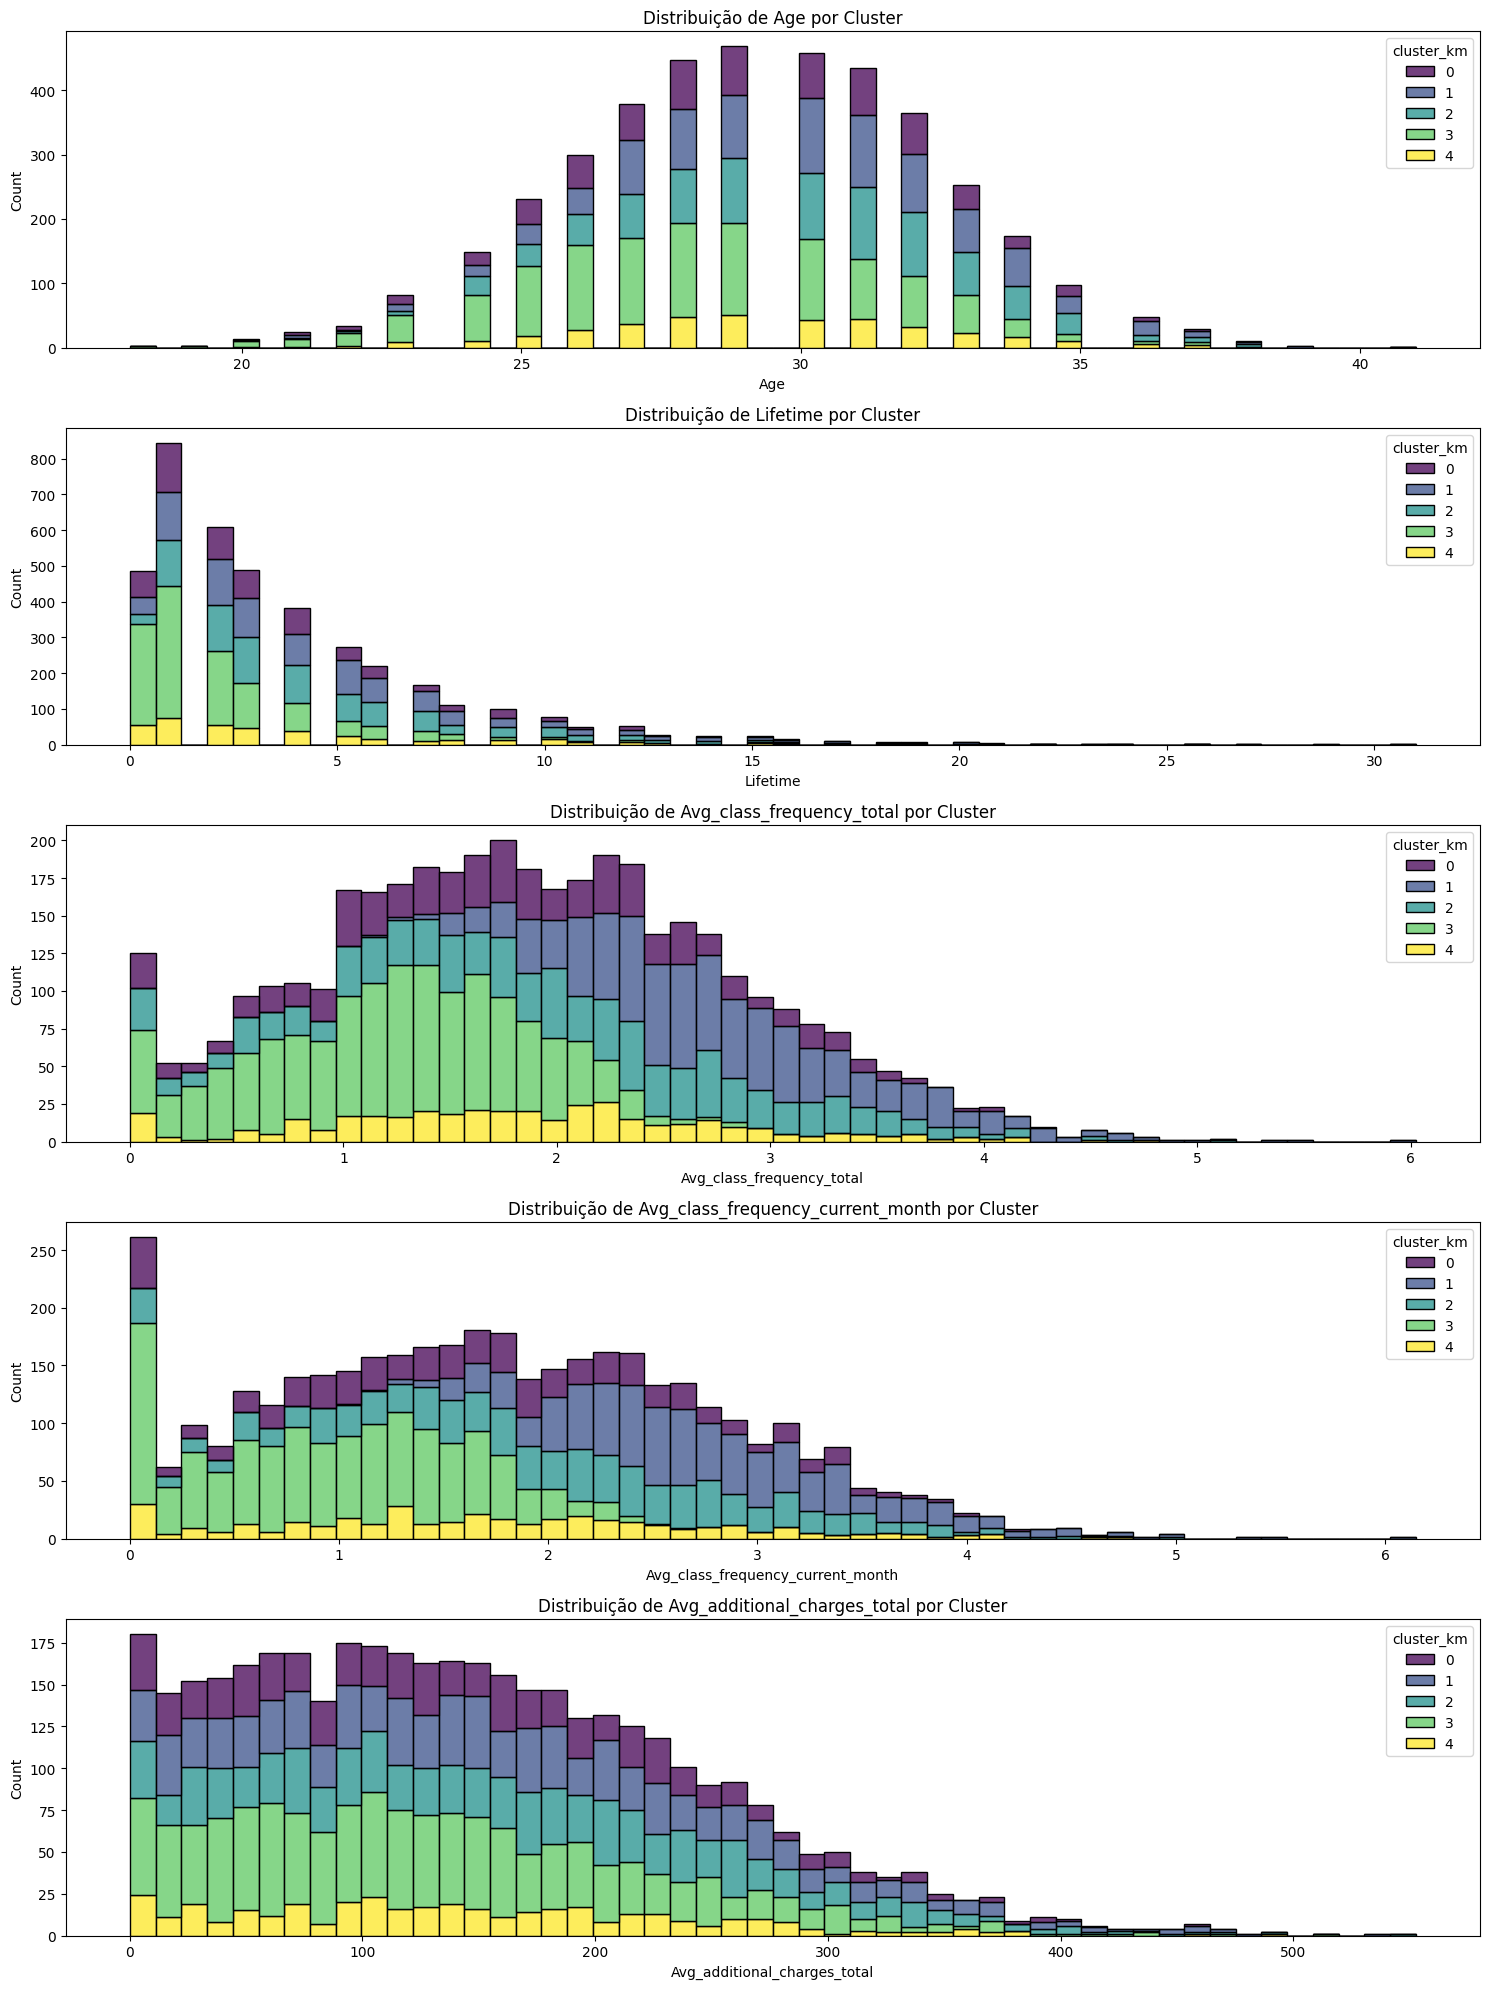

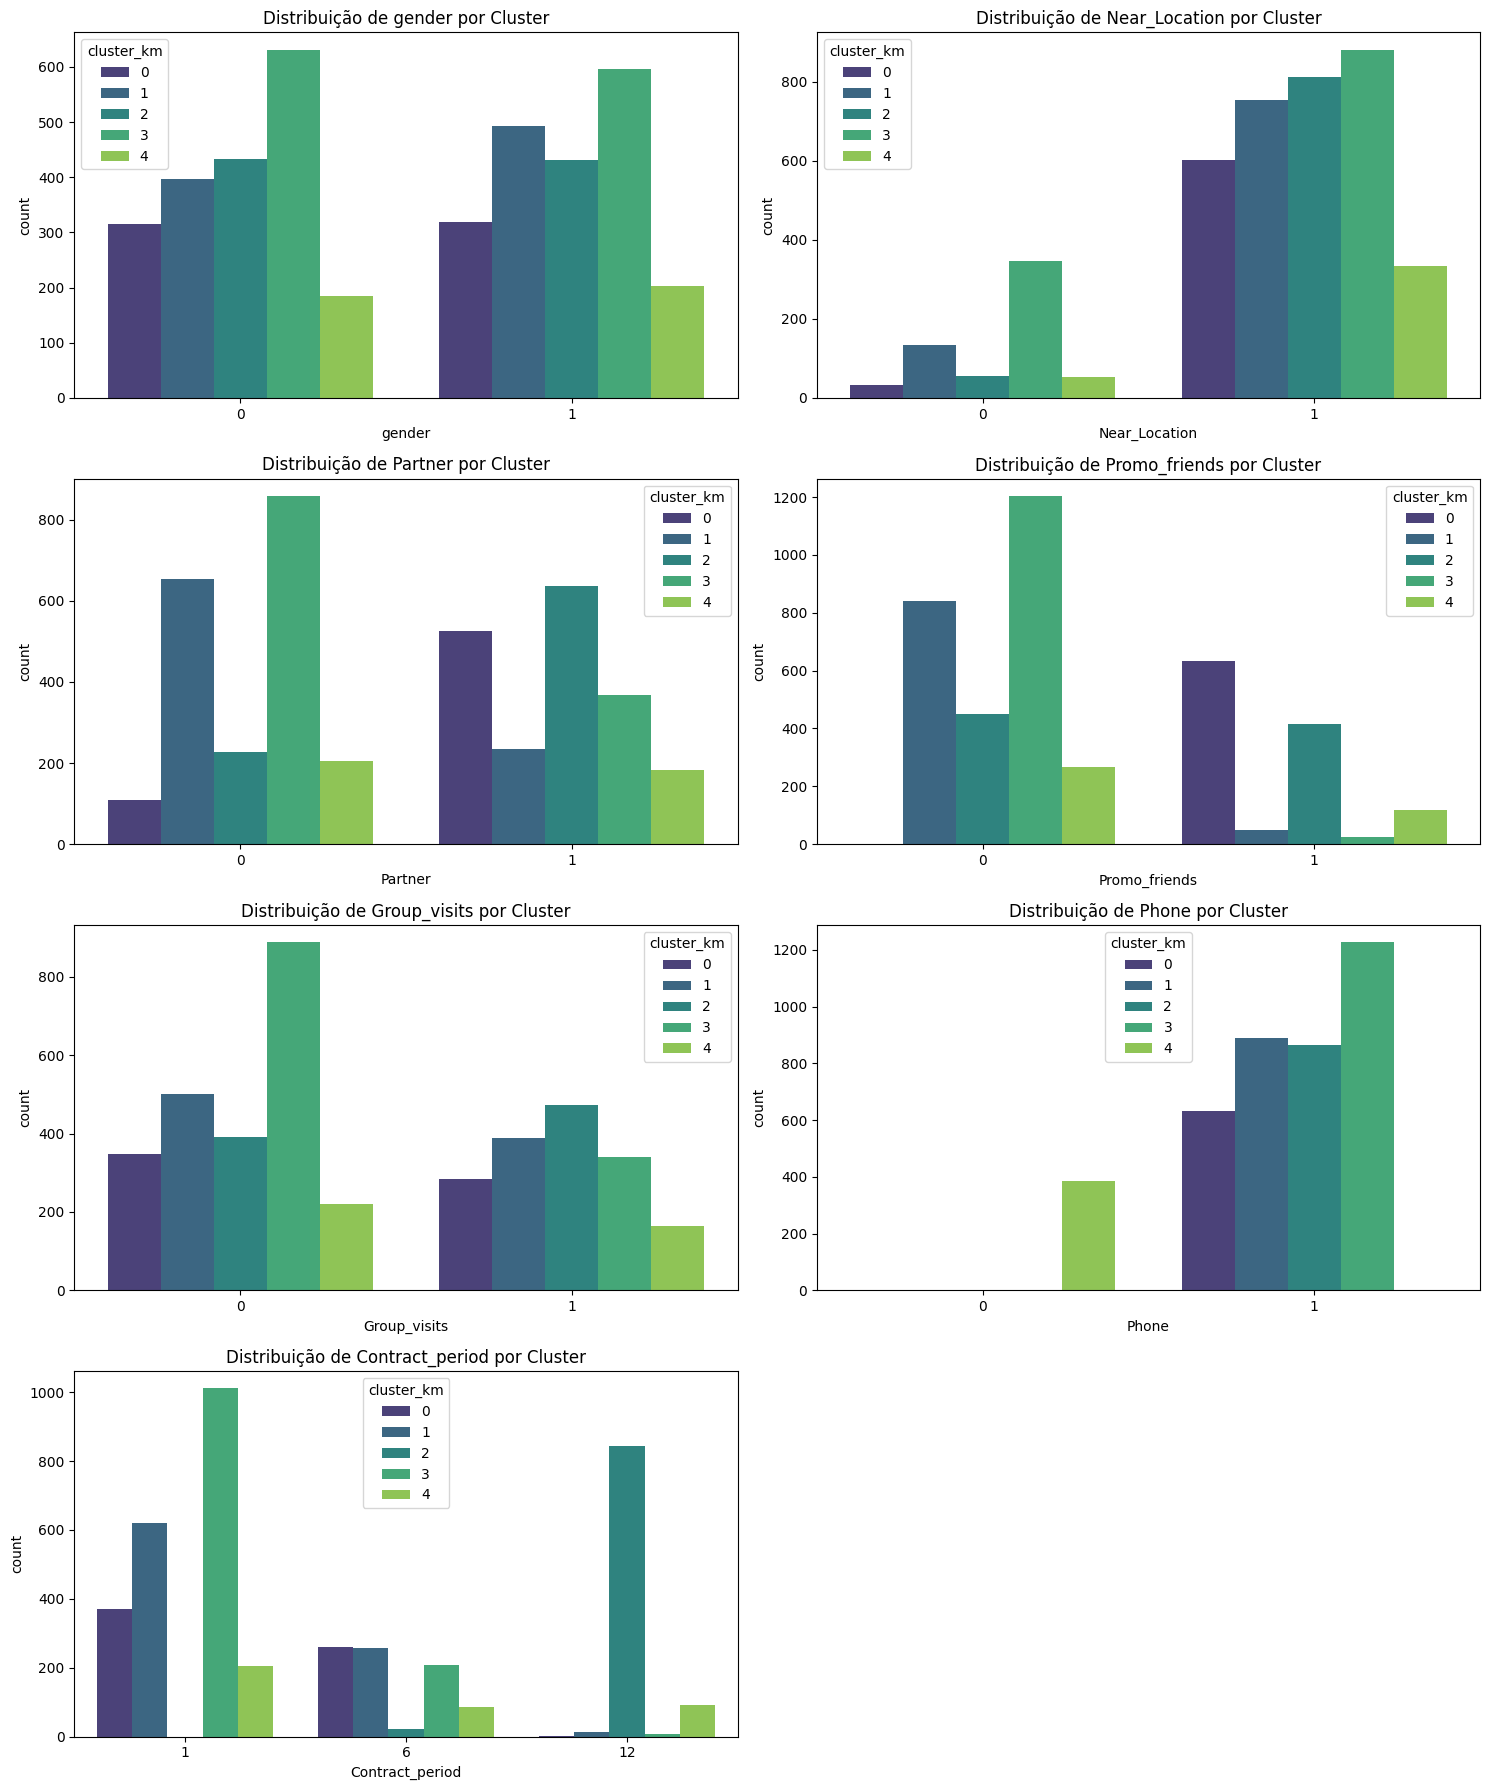

In [12]:
# Distribuição das Características Contínuas por Cluster 
continuous_cols = ['Age', 'Lifetime', 'Avg_class_frequency_total', 
                   'Avg_class_frequency_current_month', 'Avg_additional_charges_total']

plt.figure(figsize=(15, 20))
for i, col in enumerate(continuous_cols):
    plt.subplot(5, 1, i + 1)
    sns.histplot(data=df, x=col, hue='cluster_km', palette='viridis', multiple='stack', bins=50)
    plt.title(f'Distribuição de {col} por Cluster')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

# Distribuição das Características Binárias por Cluster 
binary_cols = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Group_visits', 'Phone', 'Contract_period']

plt.figure(figsize=(15, 18))
for i, col in enumerate(binary_cols):
    plt.subplot(4, 2, i + 1)
    # Convertendo Contract_period para categórica para o countplot
    if col == 'Contract_period':
        sns.countplot(x=df[col].astype('category'), hue='cluster_km', data=df, palette='viridis')
    else:
        sns.countplot(x=col, hue='cluster_km', data=df, palette='viridis')
    plt.title(f'Distribuição de {col} por Cluster')
plt.tight_layout()
plt.show()

##  Conclusões Finais e Estratégia de Retenção da Model Fitness

A análise preditiva e a segmentação de clientes confirmam que o foco principal deve ser no **engajamento inicial** e na **segurança contratual**.

---

### Análise Preditiva e Fatores Determinantes

| Modelo | Acurácia | Precisão | Sensibilidade (Recall) |
| :--- | :---: | :---: | :---: |
| Regressão Logística | **0.92** | **0.87** | **0.78** |
| Floresta Aleatória | 0.91 | 0.85 | 0.77 |

>  **Modelo de Produção Recomendado:** A **Regressão Logística** demonstrou desempenho superior em todas as métricas.
>
>  **Fator Crítico:** O `Lifetime` (Tempo de Vida) é o principal indicador de rotatividade. A falha no engajamento ocorre no **primeiro mês**.

---

### Estratégia Segmentada e Grupos Alvo (Análise K-Means)

| Cluster | Churn Rate % | Retrato e Risco | Foco Estratégico |
| :---: | :---: | :--- | :--- |
| **3** | $\mathbf{57.29\%}$ (Alto) | **O Fugitivo Rápido:** Clientes que perdem o interesse antes de se estabelecerem. | **Frequência Inicial** |
| **2** | $\mathbf{2.20\%}$ (Baixo) | **O Cliente Leal Garantido:** Estabilidade devido a Contratos Longos ($\approx 11.8$ meses) e status Partner. | **Manutenção** |
| **0** | $24.64\%$ (Risco Estrutural) | **O Cliente Promocional:** Contratos de curta duração ($\approx 3.0$ meses), maior risco de não renovação. | **Upgrade de Contrato** |
| **1** | $9.00\%$ (Baixo) | **O Atleta Dedicado:** Alta frequência ($\approx 2.7$ vezes/semana) e alto gasto adicional. | **Recompensa da Lealdade** |
| **4** | $26.68\%$ (Moderado) | **O Cliente 'Desconectado':** Único grupo com 0% de telefone fornecido, sugerindo dificuldade de engajamento digital. | **Coleta de Contato** |

---

### Medidas de Retenção (3 Princípios Essenciais)

Ações focadas em aumentar o **comprometimento** (duração do contrato) e o **engajamento** (frequência) nos primeiros meses.

| Princípio Essencial | Medida de Marketing Específica | Foco no Cliente (Cluster) |
| :--- | :--- | :--- |
| **1. Forçar o Engajamento Inicial** | Implementar um **Onboarding Obrigatório** com alerta (e-mail/SMS) para clientes com $<1$ visita na primeira semana. Oferecer uma sessão de orientação gratuita ou um *buddy pass*. | Cluster **3** (Fugitivos Imediatos) |
| **2. Aumentar a Barreira de Saída** | Lançar uma **Campanha de Upgrade** nos Meses 1-2, oferecendo crédito ou desconto substancial para migrar de contratos curtos (1 ou 3 meses) para planos de 6 ou 12 meses. | Clusters **0 e 3** (Clientes de Contrato Curto e Risco) |
| **3. Monetizar e Recompensar a Lealdade** | Criar um **Programa VIP de Fidelidade** que recompense alta frequência e alto gasto. Oferecer prioridade ou descontos em serviços auxiliares. | Cluster **1** (Dedicados) |

---

### Padrão Adicional Notado: A Questão do Contato

O Cluster 4 ($26.68\%$ de Churn) é o **único grupo onde `Phone = 0`** (nenhum cliente forneceu telefone). Isso sugere que a **falta de um canal de comunicação direta e digital** pode ser um fator de risco significativo, impedindo o marketing de engajamento da academia.

## 7. Conclusões e Recomendações

Com base no modelo preditivo (Acurácia de 92% na Regressão Logística) e na clusterização, identificamos que:

**Fatores de Risco (Churn Alto):**
* Contratos curtos (1 mês).
* Baixa frequência semanal.
* Não participam de aulas em grupo.

**Recomendações:**
1.  **Focar no "Grupo 4" (ou o número do seu cluster de risco):** Criar promoções para migração de plano mensal para semestral.
2.  **Engajamento:** Incentivar aulas em grupo nos primeiros 3 meses, pois aumenta a retenção.
3.  **Parcerias:** Expandir convênios com empresas, pois esses clientes demonstraram maior fidelidade (Cluster 2).